# Setup

In [1]:
%%capture
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns

In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/epithelial_signature_processing'

## Set up data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

# Data import

Data from: https://www.sciencedirect.com/science/article/pii/S1934590919301535?via%3Dihub <br>
Accession link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE125688 <br>
Use BEC_ctr1, BEC_ctr2, BEC_ctr3 (bil-adult1 to 3) coutt files as raw counts

In [6]:
sample1 = sc.AnnData(pd.read_csv(f"{rawDataPath}epithelial_atlases/liver_epithelium/GSM3580367_bil-adult1.coutt.csv", sep="\t").T)
sample1 = sample1[sample1.obs.index != "GENEID"]
sample1.var_names = [i.split("_")[0] for i in sample1.var_names]
sample1.obs["batch"] = "BEC_1"
sample1.obs["cell_type"] = "BEC"

In [7]:
sample2 = sc.AnnData(pd.read_csv(f"{rawDataPath}epithelial_atlases/liver_epithelium/GSM3580368_bil-adult2.coutt.csv", sep="\t").T)
sample2 = sample2[sample2.obs.index != "GENEID"]
sample2.var_names = [i.split("_")[0] for i in sample2.var_names]
sample2.obs["batch"] = "BEC_2"
sample2.obs["cell_type"] = "BEC"

In [8]:
sample3 = sc.AnnData(pd.read_csv(f"{rawDataPath}epithelial_atlases/liver_epithelium/GSM3580369_bil-adult3.coutt.csv", sep="\t").T)
sample3 = sample3[sample3.obs.index != "GENEID"]
sample3.var_names = [i.split("_")[0] for i in sample3.var_names]
sample3.obs["batch"] = "BEC_3"
sample3.obs["cell_type"] = "BEC"

## Combine data

In [9]:
adata = ad.concat([sample1, sample2, sample3], index_unique="_")

# Process data

In [10]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True, save_path=None):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    ax =sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    ax.set(yscale="log")
    ax.set(xscale="log")
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

In [11]:
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

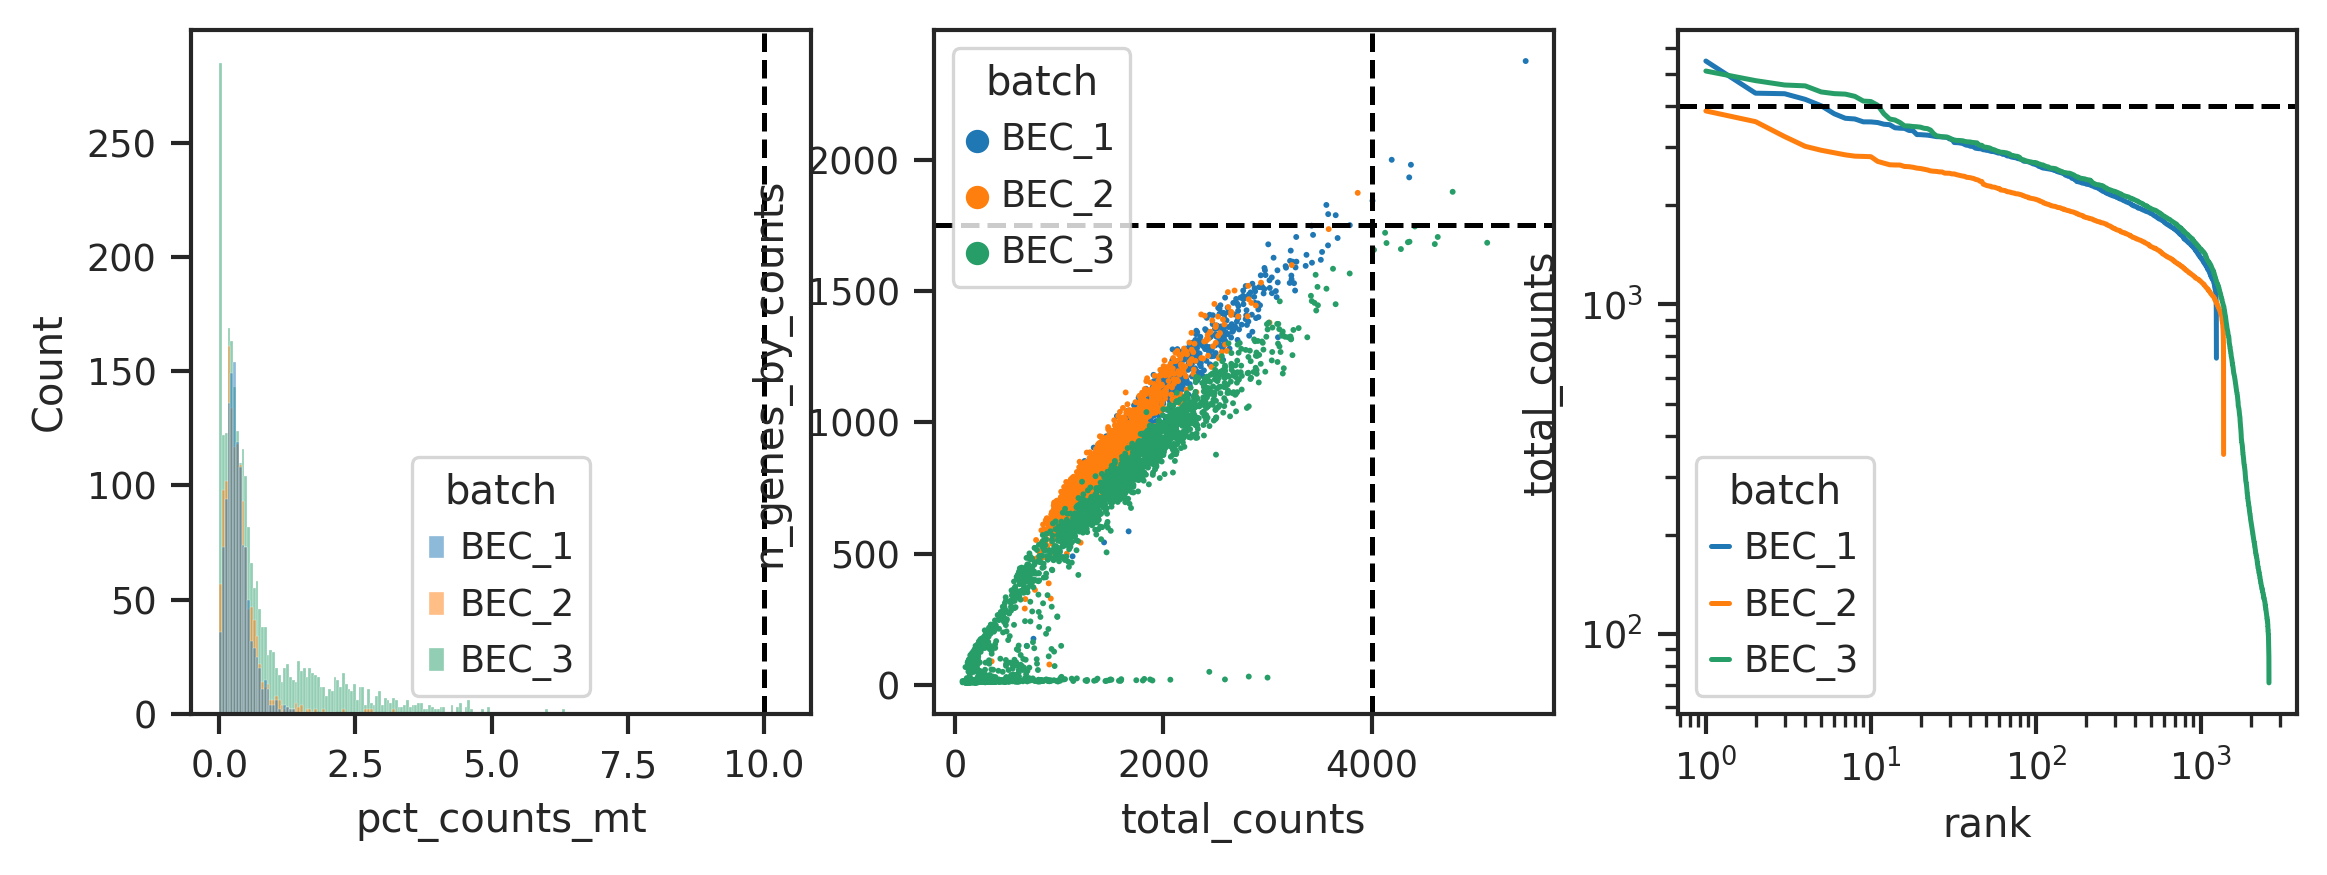

In [12]:
qc_plot(adata, counts_thresh=4000, genes_thresh=1750)

In [13]:
filteredAdata = adata[adata.obs.n_genes_by_counts >= 250]
filteredAdata = filteredAdata[filteredAdata.obs.n_genes_by_counts <= 1750]
filteredAdata = filteredAdata[filteredAdata.obs.total_counts >= 750]
filteredAdata = filteredAdata[filteredAdata.obs.total_counts <= 4000]
filteredAdata = filteredAdata[filteredAdata.obs.pct_counts_mt <= 2]

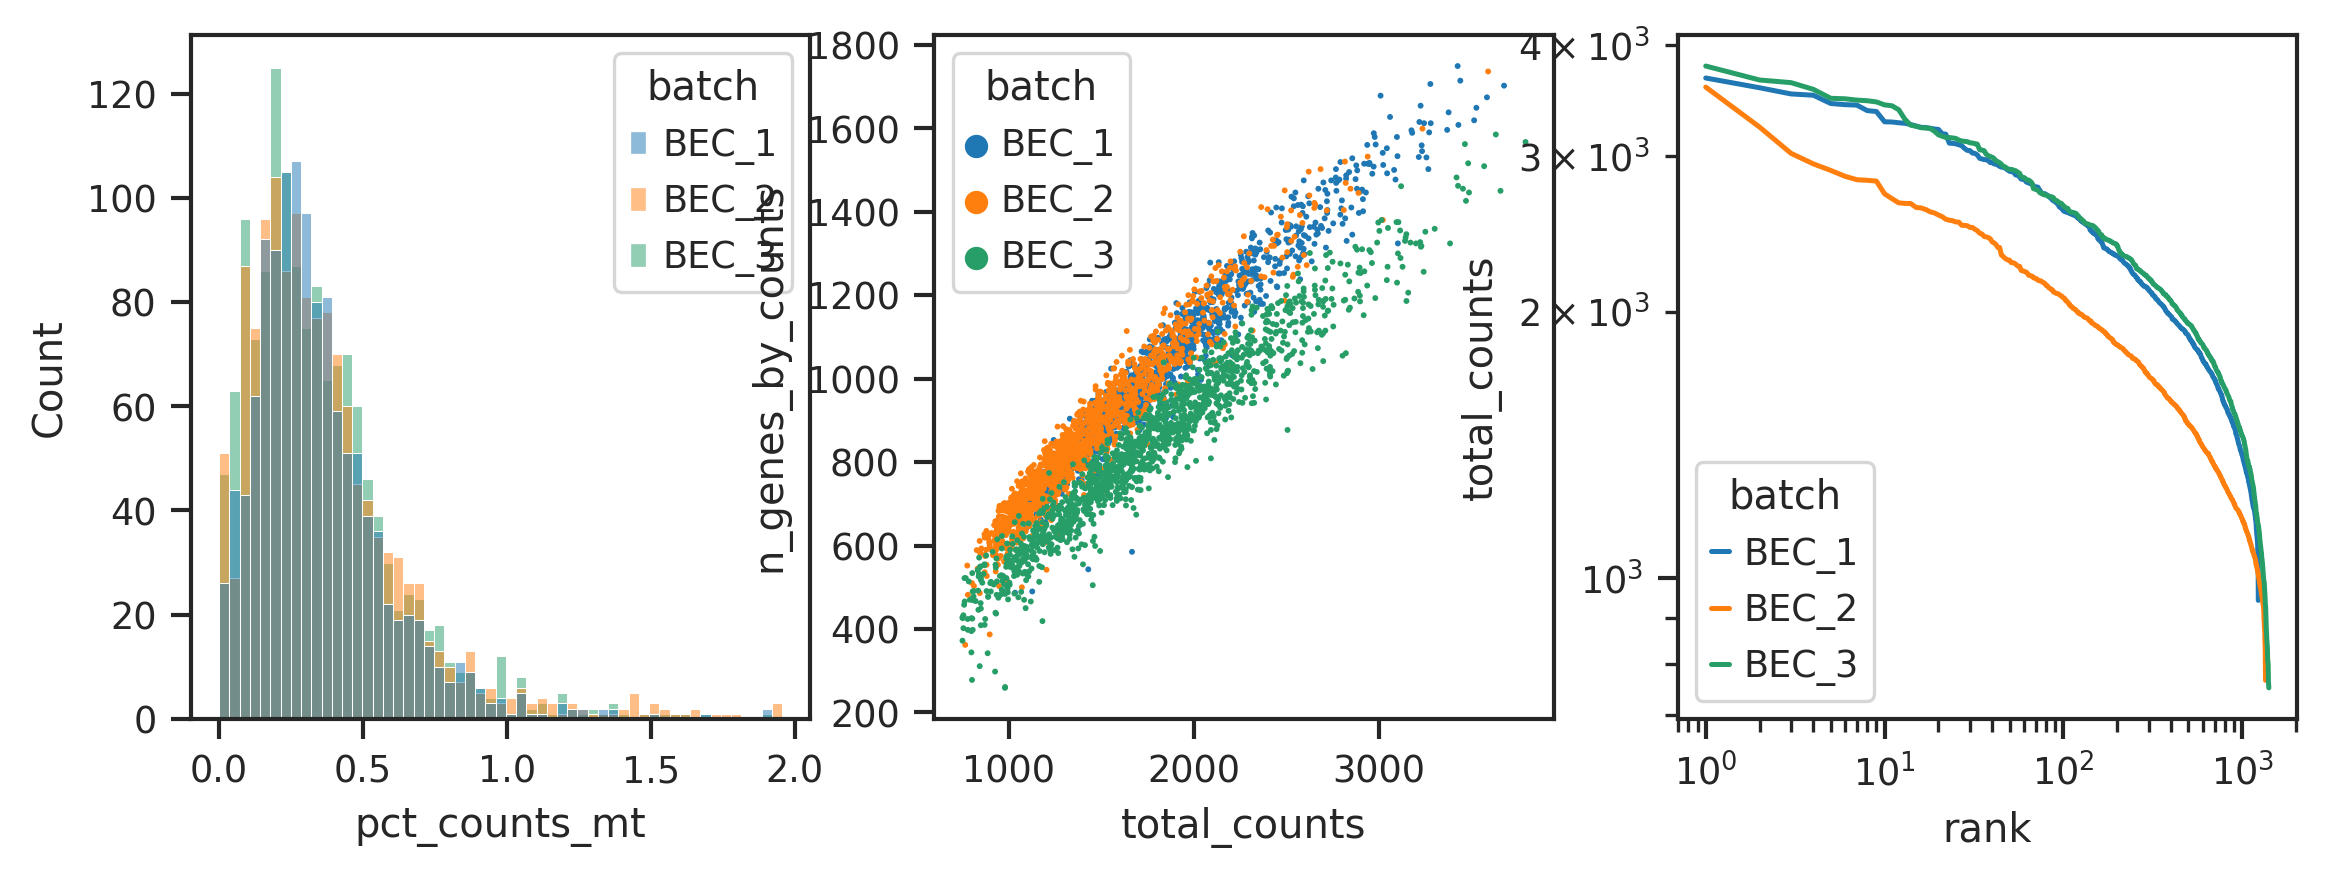

In [14]:
qc_plot(filteredAdata, show_thresh=False)

In [15]:
adata = filteredAdata
del filteredAdata

# Create pseudobulk signatures

In [16]:
def create_signature_matrix(adata, obs_key, save_path):
    signatures = pd.DataFrame(index=adata.var_names)
    for cell_type in adata.obs[obs_key].unique():
        signatures[cell_type] = list(pd.DataFrame(adata[adata.obs[obs_key] == cell_type].X).mean(axis=0))
    signatures.to_csv(save_path)
    return signatures

## Full atlas

In [17]:
signatures = create_signature_matrix(
    adata,
    "cell_type",
    "../../analysis/cell_type_signatures/liver_BEC_signature.csv")